<a href="https://colab.research.google.com/github/juanluisrosaramos/document_classification/blob/master/Text_classification_with_TF_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classifier with TF-Hub



## Preparing the environment

In [0]:
# Install the latest Tensorflow version.
!pip install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [0]:
train_df = pd.read_csv("train.csv", sep=",")

test_df = pd.read_csv("test.csv", sep=",")

In [0]:

#trainz_df = train_df[["Raw_text","Target_sign"]]
trainz_df.columns = ['sentence','polarity']
trainz_df.head()


,sentence,polarity
0,del del valdivia y can sanitario de de aptitud...,0
1,de la de la junta general de la de junio de a ...,1
2,tarragona civil grima mantenimiento y sanitari...,0
3,calleja inspector y sanitario de de aptitud lo...,1
4,interior zona m de la p de la del examen de in...,1


In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(trainz_df, test_size=0.2)

## Model
### Input functions

[Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

In [0]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

### Feature columns

TF-Hub provides a [feature column](https://github.com/tensorflow/hub/blob/master/docs/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). For the purpose of this tutorial, the most important facts are:

* The module takes **a batch of sentences in a 1-D tensor of strings** as input.
* The module is responsible for **preprocessing of sentences** (e.g. removal of punctuation and splitting on spaces).
* The module works with any input (e.g. **nnlm-en-dim128** hashes words not present in vocabulary into ~20.000 buckets).

In [0]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-es-dim128/1")

### Estimator

For classification we can use a [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier) (note further remarks about different modelling of the label function at the end of the tutorial).

In [0]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training

Train the estimator for a reasonable amount of steps.

In [0]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000);

# Prediction

Run predictions for both training and test set.

In [0]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.6994317173957825
Test set accuracy: 0.7037469744682312


## Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

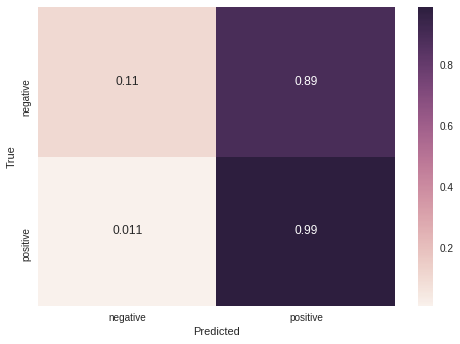

In [0]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");

## Transfer Learning analysis

Transfer learning makes it possible to **save training resources** and to achieve good model generalization even when **training on a small dataset**. In this part, we will demonstrate this by training with two different TF-Hub modules:

* **[nnlm-en-dim128](https://tfhub.dev/google/nnlm-en-dim128/1)** - pretrained text embedding module,
* **[random-nnlm-en-dim128](https://tfhub.dev/google/random-nnlm-en-dim128/1)** - text embedding module that has same vocabulary and network as **nnlm-en-dim128**, but the weights were just randomly initialized and never trained on real data.

And by training in two modes: 

* training **only the classifier** (i.e. freezing the module), and 
* training the **classifier together with the module**.

Let's run a couple of trainings and evaluations to see how using a various modules can affect the accuracy.

In [0]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
      key="sentence", module_spec=hub_module, trainable=train_module)

  estimator = tf.estimator.DNNClassifier(
      hidden_units=[500, 100],
      feature_columns=[embedded_text_feature_column],
      n_classes=2,
      optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]

  return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-es-dim128"] = train_and_evaluate_with_module("https://tfhub.dev/google/nnlm-es-dim128/1")
results["nnlm-es-dim128-with-module-training"] = train_and_evaluate_with_module("https://tfhub.dev/google/nnlm-es-dim128/1", True)
results["nnlm-es-dim50"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-es-dim50/1")
results["nnlm-es-dim50-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-es-dim50/1", True)


Let's look at the results.

In [0]:
pd.DataFrame.from_dict(results, orient="index")

,Training accuracy,Test accuracy
nnlm-en-dim128,0.697047,0.701259
nnlm-es-dim128-with-module-training,0.701901,0.705783
nnlm-es-dim50,0.694786,0.699261
nnlm-es-dim50-with-module-training,0.702184,0.705029


In [0]:
estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]

0.67370325